In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
player_data <- read_csv("data/players.csv") |>
    mutate(experience = as.factor(experience))

player_data <- player_data |> 
    mutate(cat_hours = cut(played_hours, breaks = c(0,1,5,10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, Inf), include.lowest=TRUE))

player_data

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName,cat_hours
<fct>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>,<fct>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA,"(30,40]"
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA,"(1,5]"
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA,"[0,1]"
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17,NA,NA,"[0,1]"
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17,NA,NA,"(1,5]"
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,91,NA,NA,"[0,1]"


In [3]:
set.seed(3456) 

hours_split <- initial_split(player_data, prop = 0.75, strata = cat_hours)  
hours_train <- training(hours_split)   
hours_test <- testing(hours_split)

In [4]:
hours_recipe <- recipe(cat_hours ~ age + experience, data = hours_train) |>
   step_scale(all_numeric_predictors()) |>
   step_center(all_numeric_predictors())

hours_vfold <- vfold_cv(hours_train, v = 5, strata = cat_hours)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

knn_results <- workflow() |>
      add_recipe(hours_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = hours_vfold, grid = k_vals) |>
      collect_metrics()

knn_results

→ A | warning: ✖ No observations were detected in `truth` for levels: (5,10], (15,20],
                 (30,40], (40,50], (60,70], (70,80], (80,90], (90,100], (100,150], and
                 (150,200].
               ℹ Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

→ B | warning: ✖ No observations were detected in `truth` for levels: (5,10], (10,15],
                 (15,20], (20,30], (30,40], (40,50], (50,60], (60,70], (70,80], (80,90],
                 (90,100], (150,200], and (200,Inf].
               ℹ Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1
→ C | warning: ✖ No observations were detected in `truth` for levels: (5,10], (10,15],
                 (20,30], (50,60], (60,70], (70,80], (80,90], (90,100], (100,150], (150,200],
                 and (200,Inf].
               ℹ Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1
T

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.3772414,5,0.06865101,Preprocessor1_Model01
1,roc_auc,hand_till,0.4470065,5,0.01926086,Preprocessor1_Model01
2,accuracy,multiclass,0.3905747,5,0.06614980,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
9,roc_auc,hand_till,0.5321796,5,0.01892380,Preprocessor1_Model09
10,accuracy,multiclass,0.8149425,5,0.01784388,Preprocessor1_Model10
10,roc_auc,hand_till,0.5124758,5,0.01820064,Preprocessor1_Model10


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_line()`).”


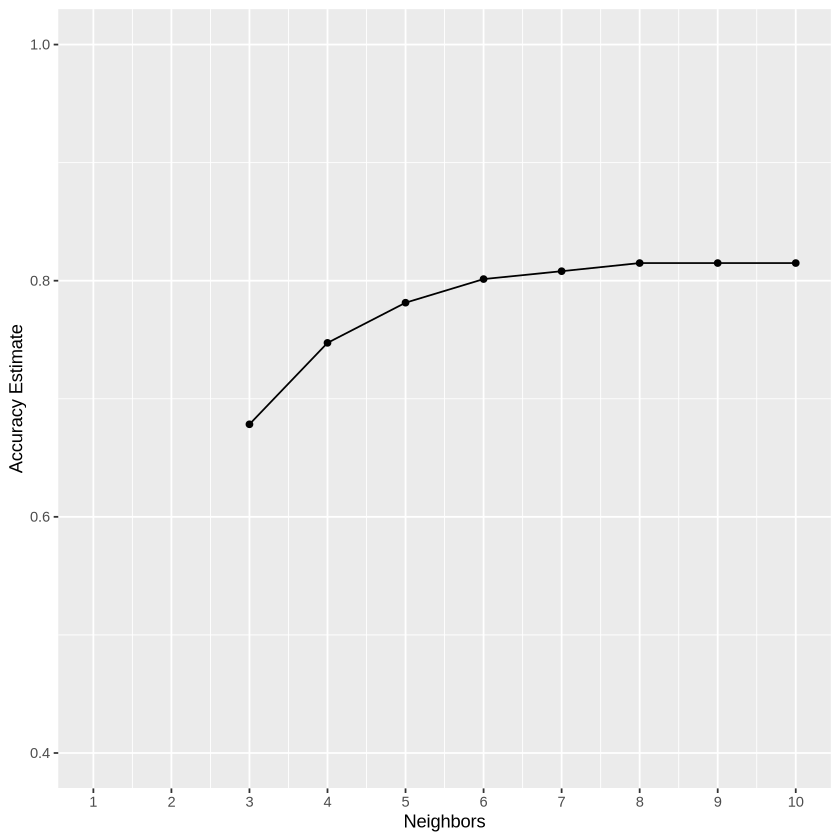

In [5]:
accuracies <- knn_results |> 
      filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

accuracy_versus_k

In [6]:
set.seed(2020)

knn_hours <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) |>
      set_engine("kknn") |>
      set_mode("classification")

hours_fit <- workflow() |>
      add_recipe(hours_recipe) |>
      add_model(knn_hours) |>
      fit(data = hours_train)

hours_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(6,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1917808
Best kernel: rectangular
Best k: 6

In [7]:
hours_test_predictions <- predict(hours_fit , hours_test) |>
      bind_cols(hours_test)

hours_test_accuracy <- hours_test_predictions |>
    metrics(truth = cat_hours, estimate = .pred_class)

hours_test_predictions
hours_test_accuracy

.pred_class,experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName,cat_hours
<fct>,<fct>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>,<fct>
"[0,1]",Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA,"[0,1]"
"[0,1]",Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA,"[0,1]"
"[0,1]",Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA,"[0,1]"
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
"[0,1]",Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22,NA,NA,"[0,1]"
"[0,1]",Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17,NA,NA,"[0,1]"
"[0,1]",Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,91,NA,NA,"[0,1]"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.82
kap,multiclass,0.00
